In [29]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



In [30]:
weather = pd.read_csv("london_weather.csv")


# converting the date format
weather["date"] = weather["date"].apply(lambda x:pd.to_datetime(str(x), format = '%Y%m%d'))

# taking the month
weather["month"] = weather["date"].dt.month
weather["year"] = weather["date"].dt.year
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1979
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1,1979
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1,1979
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1,1979
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1,1979


In [31]:
print(weather.head())
print(weather.describe())

        date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0 1979-01-01          2.0       7.0              52.0       2.3       -4.1   
1 1979-01-02          6.0       1.7              27.0       1.6       -2.6   
2 1979-01-03          5.0       0.0              13.0       1.3       -2.8   
3 1979-01-04          8.0       0.0              13.0      -0.3       -2.6   
4 1979-01-05          6.0       2.0              29.0       5.6       -0.8   

   min_temp  precipitation  pressure  snow_depth  month  year  
0      -7.5            0.4  101900.0         9.0      1  1979  
1      -7.5            0.0  102530.0         8.0      1  1979  
2      -7.2            0.0  102050.0         4.0      1  1979  
3      -6.5            0.0  100840.0         2.0      1  1979  
4      -1.4            0.0  102250.0         1.0      1  1979  
                      date   cloud_cover      sunshine  global_radiation  \
count                15341  15322.000000  15341.000000      15322.00000

In [32]:
weather[["mean_temp","month"]].groupby(["month"]).mean()

,mean_temp
month,
1,5.162462
2,5.398986
3,7.606091
4,10.097615
5,13.398921
6,16.459459
7,18.795158
8,18.451424
9,15.735959


<Axes: xlabel='month', ylabel='mean_temp'>

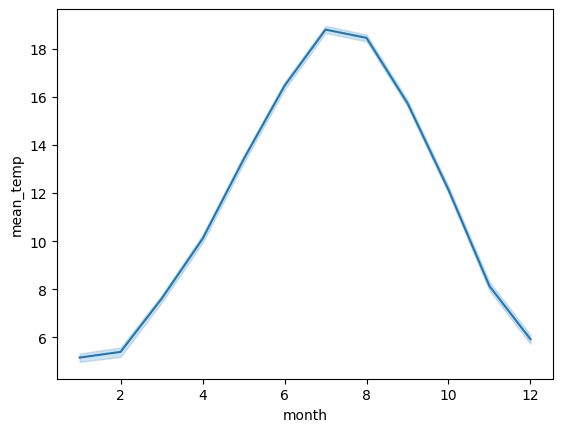

In [33]:
sns.lineplot(data=weather, x="month", y="mean_temp")

<Axes: xlabel='year', ylabel='mean_temp'>

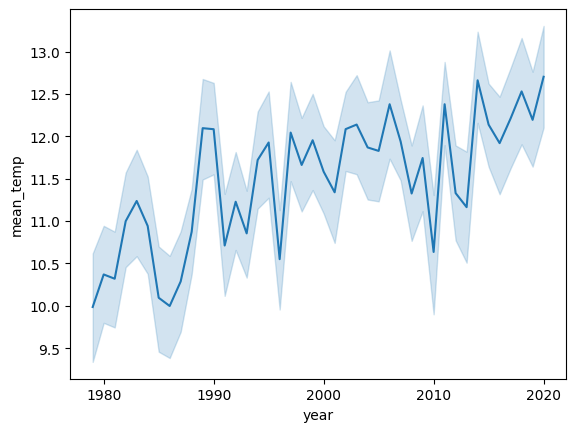

In [34]:
sns.lineplot(data=weather, x="year", y="mean_temp")

[Text(0.5, 1.0, 'Correlation between variables')]

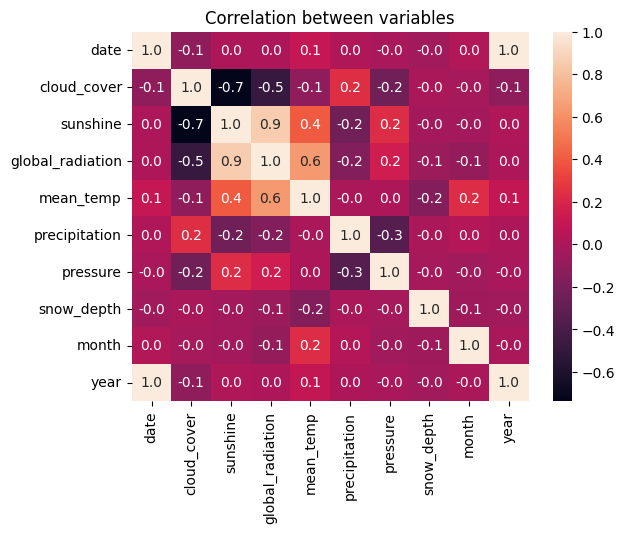

In [35]:
weather_corr = weather.drop(["max_temp","min_temp"], axis=1).corr()
sns.heatmap(weather_corr, annot=True, fmt=".1f").set(title="Correlation between variables")


In [36]:
feature_selection = ["global_radiation","sunshine","month","cloud_cover","precipitation","pressure"]
weather = weather.dropna(subset=['mean_temp'])
X = weather[feature_selection]
y = weather[["mean_temp"]]
# X.head()

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Impute misising value
imputer = SimpleImputer(strategy="mean")
# Fit on the training data
X_train = imputer.fit_transform(X_train)
# Transform on the test data
X_test = imputer.transform(X_test)


# Scale the data
scaler = StandardScaler()
# Fit on the training data
X_train = scaler.fit_transform(X_train)
# Transform on the test data
X_test = scaler.transform(X_test)


In [41]:
# Predict, evaluate, and log the parameters and metrics of your models
for idx, depth in enumerate ([1, 5]):
    run_name = f"run_{idx}"
    print(run_name)
    with mlflow.start_run(run_name = run_name):

        #Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        
        #Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
    
        #Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared = False)
        
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared = False)
        
        y_pred_forest_reg = forest_reg.predict(X_test)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        
        #Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_LR", lin_reg_rmse)
        mlflow.log_metric("rmse_TR", tree_reg_rmse)
        mlflow.log_metric("rmse_RF", forest_reg_rmse)
              
  
        
#Search the runs for the experiment's results
experiment_results = mlflow.search_runs()
experiment_results

run_0


MissingConfigException: Yaml file '/Users/studytube/OTHER_DOCUMENTS/STUDY/GITHUB_REPOS/datacamp-london-tempereature-prediction/mlruns/0/meta.yaml' does not exist.

In [ ]:
# ## This code is to delete the runs in the experiment

# run_ids = experiment_results["run_id"].to_list()
# for run_id in run_ids:
#     print(run_id)
    
#     # mlflow.delete_run(run_id)
# mlflow.delete_run('3ab2b070f1fd42358866babd5da9e193')
# experiment_results
# # m